In [101]:
import duckdb
from lonboard import Map, PolygonLayer, viz
from lonboard.colormap import apply_continuous_cmap, apply_categorical_cmap
from matplotlib.colors import LogNorm
from palettable.colorbrewer.sequential import Oranges_6
import palettable.colorbrewer.diverging
from matplotlib.colors import LogNorm



In [102]:
duckdb.sql('install spatial;load spatial;')

In [103]:
query = duckdb.sql("""
    WITH areas AS (
        SELECT names.primary as name,
               ST_GeomFromWKB(geometry) as area_geom
        FROM '../data/bretagne-division_area.parquet'
        WHERE subtype = 'locality' and region = 'FR-BRE'
        ),
    schools AS (
        SELECT ST_GeomFromWKB(geometry) as school_geom
        FROM '../data/bretagne-place.parquet'
        WHERE categories.main = 'school'
        )
    SELECT name, area_geom, count(school_geom) as school_count, count(school_geom) as count 
    FROM areas LEFT JOIN schools ON ST_Contains(area_geom, school_geom)
    GROUP BY area_geom, name
""")

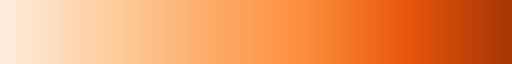

In [104]:
Oranges_6.mpl_colormap

In [105]:
gdf = query.df()
gdf.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name,area_geom,school_count,count
0,Lorient,"[5, 4, 0, 0, 0, 0, 0, 0, 134, 68, 90, 192, 147...",14,14
1,Plouhinec,"[2, 4, 0, 0, 0, 0, 0, 0, 210, 101, 83, 192, 18...",2,2
2,Saint-Gildas-de-Rhuys,"[2, 4, 0, 0, 0, 0, 0, 0, 155, 158, 55, 192, 88...",2,2
3,Larmor-Baden,"[5, 4, 0, 0, 0, 0, 0, 0, 163, 135, 58, 192, 13...",2,2
4,Ploeren,"[2, 4, 0, 0, 0, 0, 0, 0, 249, 145, 56, 192, 10...",1,1


In [106]:
df_school = gdf["school_count"]
normalizer= LogNorm(1, df_school.max(), clip=True)

normalized_count = normalizer(df_school)
normalized_count

masked_array(data=[0.5465795043985202, 0.14355885269113103,
                   0.14355885269113103, ..., 0.0, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [107]:
layer = PolygonLayer.from_duckdb(
    query,
    get_line_color=[200,200,200],
    line_width_units='pixels',
)
layer.get_fill_color = [100,100,100]


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/home/fgravin/dev/rnd/overturemaps/overturemaps-py/.venv/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:23: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


In [108]:
m = Map(layer)
m


Map(layers=[PolygonLayer(get_fill_color=[100, 100, 100], get_line_color=[200, 200, 200], line_width_units='pix…

In [109]:
layer.get_fill_color = apply_continuous_cmap(
    normalized_count, Oranges_6, alpha=0.9
)
